In [1]:
import numpy as np
import talib as ta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Input, concatenate, Layer, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import platform
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = ['Songti SC']
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = ['SimSun']
else:  # Linux
    plt.rcParams['font.family'] = ['Noto Sans CJK SC']

In [2]:
# ================== 增强版数据预处理 ==================
def preprocess_data(file_path, time_scales=['30min']):

    # 技术指标计算
    def add_technical_indicators(df):
        # 价格特征
        # df['price_diff'] = df['close'].diff()
        # df['returns'] = df['close'].pct_change()
        
        # # 波动率指标
        # df['volatility_20'] = df['returns'].rolling(20).std()
        
        # # 技术指标
        # df['MA_10'] = df['close'].rolling(10).mean()
        # df['RSI'] = ta.RSI(df['close'], window=14)
        # df['MACD'], df['Signal'], df['Hist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
        return df.dropna()

    # 多尺度特征工程
    scaled_data = {}
    time_indices = {}  # 新增时间索引字典
    for scale in time_scales:
        # 重采样
        # 读取原始数据
        resampled = pd.read_csv(f"{file_path}/train-{scale}.csv", parse_dates=['date'], index_col='date')
        
        # 添加技术指标
        resampled = add_technical_indicators(resampled)
        # 归一化处理
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled = scaler.fit_transform(resampled)
        
        # 构建3D时序数据 [samples, timesteps, features]
        seq_length = 60  # 使用60个时间窗口
        X, y = [], []
        for i in range(len(scaled)-seq_length-1):
            X.append(scaled[i:i+seq_length])
            y.append(scaled[i+seq_length, 3])  # 预测close价格

        X = np.array(X).reshape(-1, seq_length, resampled.shape[1])
        scaled_data[scale] = (X, np.array(y))
        # scaled_data[scale] = (np.array(X), np.array(y))
        # 保存对应的时间索引（后移seq_length+1的位置）
        time_indices[scale] = resampled.index[seq_length+1:]
    
    return scaled_data, scaler, time_indices

In [3]:
# ================== MoE 模型架构 ==================
class ExpertNetwork(Layer):
    def __init__(self, units =[64,32], input_dim=None, dense=None, dropout_rate=0.2, **kwargs):
        """
        参数化专家网络
        Args:
            units (list): LSTM各层单元数，如[64,32]表示两个LSTM层
            dropout_rate (float): Dropout比率
        """
        super(ExpertNetwork, self).__init__(**kwargs)
        self.input_dim = input_dim  # 显式定义输入维度
        self.dense_layers = []
        self.dropout_stack = []
        self.lstm_stack = []
        self.dropout_rate = dropout_rate
        # 动态创建LSTM层
        for i, unit in enumerate(units):
            is_last_layer = (i == len(units)-1)
            self.lstm_stack.append(
                LSTM(unit, 
                     input_dim=input_dim,  # 关键修改处
                     return_sequences=not is_last_layer, 
                     kernel_regularizer=tf.keras.regularizers.l1_l2(0.01, 0.01),
                     recurrent_activation='sigmoid')
            )
            self.dropout_stack.append(tf.keras.layers.Dropout(dropout_rate))
        if dense:
            for i in range(len(dense)):
                """Dense层"""
                self.dense_layers.append(
                    tf.keras.layers.Dense(units=dense[i], activation='relu')
                )
        # 修正最后一层LSTM的return_sequences
        self.lstm_stack[-1].return_sequences = False
        # 添加形状追踪
        self.output_dim = units[-1]  # 记录最后一层LSTM单元数
        # 必须显式注册子层才能追踪参数
        for i, (lstm, dropout) in enumerate(zip(self.lstm_stack, self.dropout_stack)):
            setattr(self, f"lstm_{i}", lstm)
            setattr(self, f"dropout_{i}", dropout)
        self.final_dense = Dense(1)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    def build(self, input_shape):
        # 显式构建各层
        current_shape = input_shape
        for i, (lstm, dropout) in enumerate(zip(self.lstm_stack, self.dropout_stack)):
            lstm.build(input_shape)
            print(f"LSTM{i}输入形状: {current_shape} -> 输出形状: {lstm.compute_output_shape(current_shape)}")

            dropout.build(lstm.compute_output_shape(current_shape))
            current_shape = lstm.compute_output_shape(current_shape)
        # 验证最终形状
        print(f"最终Dense层输入形状: {current_shape}")
        # 构建最终Dense层
        self.final_dense.build(current_shape)
        
        # 必须调用父类方法
        super().build(input_shape)

    """重写方法，确认输出形状"""
    def compute_output_shape(self, input_shape):
        print(f"input_shape: {input_shape}")
        return (input_shape[0], 1)  # (batch_size, 1)
    """重写方法，获取配置信息"""
    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units, "dropout_rate": self.dropout_rate})
        return config
    
    def call(self, inputs):
        assert inputs.shape[-1] == self.input_dim, \
            f"输入特征维度{inputs.shape[-1]}与网络配置{self.input_dim}不匹配"
        x = inputs
         # 添加维度检查
        if len(x.shape) == 2:  # 如果输入是二维 (batch, features)
            x = tf.expand_dims(x, axis=1)  # 变为 (batch, 1, features)
        for lstm, dropout in zip(self.lstm_stack[:-1], self.dropout_stack[:-1]):
            x = lstm(x)
            x = dropout(x)
        x = self.lstm_stack[-1](x)
        for dense in self.dense_layers:
            x = dense(x)
        return self.final_dense(x)

class MoE(Model):
    def __init__(self, num_experts,input_dims, attention_units=32, expert_config =None, time_scales = None, **kwargs):
        """
        可配置的MoE模型
        Args:
            num_experts (int): 专家数量
            expert_config (dict): 专家网络配置字典，包含：
                - units: 各专家LSTM层配置（列表的列表）
                - dropout_rates: 各专家dropout比率
            time_scales (list): 时间尺度列表
            attention_units (int): 注意力层单元数
        """
        super(MoE, self).__init__(**kwargs)
        # 专家网络默认配置
        default_expert_config = {
            'units': [[64,32]]*num_experts,
            'dropout_rates': [0.2]*num_experts
        }
        if expert_config:
            default_expert_config.update(expert_config)

        self.experts = [ExpertNetwork(units=default_expert_config['units'][i],
                                      input_dim=input_dims[i],  # 添加输入维度参数
                                      dropout_rate=default_expert_config['dropout_rates'][i]
                                      ) for i in range(num_experts)]
        # 注意力层
        self.attention = Attention(use_scale=True, score_mode="dot", 
                                   dropout = default_expert_config.get('attention_dropout', 0.1))
        # 门控层
        self.gate = Dense(num_experts, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.01))

        self.final_dense = Dense(1,  
                                 activation='linear',
                                 kernel_initializer='he_normal')
        self.time_scales = time_scales or []

    def build(self, input_shapes):
         # 显式构建每个专家的输入处理路径
        self.expert_inputs = []
        for i, shape in enumerate(input_shapes):
            expert_input = Input(shape=shape[1:], name=f"expert_{i}_input")
            self.expert_inputs.append(expert_input)
            processed = self.experts[i](expert_input)
            self.experts[i].built = True  # 强制标记为已构建

        # 显式定义所有层的输入形状
        self.attention.build(input_shape=[(None, 1, len(self.experts)), (None, 1, len(self.experts)), (None, 1, len(self.experts))])
        self.gate.build(input_shape=(None, len(self.experts)))
        self.final_dense.build(input_shape=(None, len(self.experts)))

        super().build(input_shapes)
        
    def call(self, inputs):
        # 如果inputs是一个包含单个元组的列表，先解包
        if isinstance(inputs, tuple) and len(inputs) > 1:
            inputs = inputs[0]
        if isinstance(inputs, (list, tuple)):
            inputs = list(inputs)  # 确保列表格x式
        else:
            inputs = [inputs]  
        for i, inp in enumerate(inputs):
            print(f"专家 {i} 输入形状: {inp.shape} 配置: {self.experts[i].lstm_stack[0].units} units")
            # 添加维度展开处理
            if isinstance(inp, tuple):
                inp = inp[0]
                inputs[i] = inp
        # 确保输入对齐
        if len(inputs) != len(self.experts):
            raise ValueError(f"输入数量({len(inputs)})与专家数量({len(self.experts)})不匹配")
        
        # 专家输出
        # 显式调用各专家网络
        expert_outputs = [expert(inp) for expert, inp in zip(self.experts, inputs)]

        
        # 动态路由
        concatenated = concatenate(expert_outputs, axis=-1)
        # 添加维度扩展（可选，根据Attention层需求）
        concatenated = tf.expand_dims(concatenated, axis=1) # 变为 (batch_size, 1, num_experts)
        print(f"Concatenated shape: {concatenated.shape}")

        # 修改后的打印语句
        for i, out in enumerate(expert_outputs):
            print(f"Expert {i} output shape: {out.shape}")

        # Attention层 注意力计算
        if len(self.experts) > 1:
            attention_inputs = [concatenated]*3
        else:
            attention_inputs = [concatenated, concatenated, concatenated]  # 使用自注意力模式

        # 根据需求设置是否使用因果掩码
        attention_output = self.attention(inputs=attention_inputs,use_causal_mask=False)

        print(f"Attention输出形状: {attention_output.shape}")
        gated_output = tf.reduce_sum(attention_output * concatenated, axis=1)
        
        # 门控融合
        gate_weights = self.gate(gated_output)
        weighted_output = tf.reduce_sum(gate_weights * concatenated, axis=1)
        
        return self.final_dense(weighted_output)

# ================== 模型训练 ==================
def train_moe_model(data_dict,  model_config=None,
                    train_config=None, epochs= 20):

    """
    可配置的训练函数
    Args:
        model_config (dict): 模型配置参数，包含：
            - num_experts
            - expert_config
            - attention_units
        train_config (dict): 训练配置参数，包含：
            - epochs
            - batch_size
            - learning_rate
            - early_stop_patience
    """
    # 合并默认配置
    default_model_config = {
        'num_experts': len(data_dict),
        'expert_config': None,
        'attention_units': 32
    }
    if model_config:
        default_model_config.update(model_config)

    print(f'当前模型配置：{default_model_config}')
    default_train_config = {
        'epochs': 50,
        'batch_size': 128,
        'learning_rate': 0.001,
        'optimizer': 'adam',
        'early_stop_patience': 5
    }
    if train_config:
        default_train_config.update(train_config)
    print(f'当前训练配置：{default_train_config}')
    # 初始化模型
    input_dims = [data[0].shape[-1] for data in data_dict.values()]
    model = MoE(num_experts=default_model_config['num_experts'], 
                input_dims=input_dims,  # 传入实际特征维度
                expert_config=default_model_config['expert_config'],
                time_scales=data_dict.keys())
    
    # 准备多尺度输入数据
    X_list = [data[0] for data in data_dict.values()]
    y = list(data_dict.values())[0][1]  # 假设所有尺度使用相同目标

    # 添加输入层定义
    input_shapes = [x.shape[1:] for x in X_list]
    # model.build(input_shapes)
    model.build([(None,) + shape for shape in input_shapes])  # 显式定义输入形状

    print(f"专家网络参数数量: {model.experts[0].count_params()}")
    # 添加层连接可视化
    tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')
    # 模型编译
    optimizer_map = {
        'adam': tf.keras.optimizers.Adam,
        'adamax': tf.keras.optimizers.Adamax,
        'rmsprop': tf.keras.optimizers.RMSprop
    }
    optimizer = optimizer_map[default_train_config['optimizer']](
        learning_rate=default_train_config['learning_rate']
    )
    model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['mae','mse'])
    model.summary(expand_nested=True, show_trainable=True)
    # 早停策略
    es = EarlyStopping(monitor='val_loss', 
                       patience=default_train_config['early_stop_patience'],
                       restore_best_weights=True)

    # 模型训练
    history = model.fit(X_list, y,
                      epochs=default_train_config['epochs'],
                      batch_size=default_train_config['batch_size'],
                      validation_split=0.2,
                      callbacks=[es],
                      verbose=1)
    return model, history

In [4]:
# 数据预处理
data_scaled, scaler, _ = preprocess_data('../data/')
# 定义实验配置
experiment_config = {
    'model_config': {
        'num_experts': len(data_scaled),
        'expert_config': {
            'units': [
                [31, 64],  # 专家1的LSTM结构
                [31, 32],    # 专家2的LSTM结构
                [31, 32]    # 专家2的LSTM结构
            ],
            'dense_layer':[64],
            'dropout_rates': [0.3, 0.2],
            'attention_dropout': 0.1
        },
        'attention_units': 64
    },
    'train_config': {
        'epochs': 20,
        'batch_size': 256,
        'learning_rate': 0.0005,
        'optimizer': 'adamax',
        'early_stop_patience': 7
    }
}

# 模型训练
moe_model, history = train_moe_model(data_scaled,
                            model_config=experiment_config['model_config'],
                            train_config=experiment_config['train_config'])


当前模型配置：{'num_experts': 1, 'expert_config': {'units': [[31, 64], [31, 32], [31, 32]], 'dense_layer': [64], 'dropout_rates': [0.3, 0.2], 'attention_dropout': 0.1}, 'attention_units': 64}
当前训练配置：{'epochs': 20, 'batch_size': 256, 'learning_rate': 0.0005, 'optimizer': 'adamax', 'early_stop_patience': 7}
LSTM0输入形状: (None, 60, 31) -> 输出形状: (None, 60, 31)


d:\Programs\miniconda3\envs\tf310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM1输入形状: (None, 60, 31) -> 输出形状: (None, 64)
最终Dense层输入形状: (None, 64)
input_shape: (None, 60, 31)
专家网络参数数量: 32453
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Model: "mo_e"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ expert_network              │ (None, 1)             │     32,453 │   Y   │
│ (ExpertNetwork)             │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ attention (Attention)       │ (None, 1, 1)          │          1 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 1)             │          2 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 1)             │          2 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 32,458 (126.79 KB)

 Trainable params: 32,458 (126.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
专家 0 输入形状: (None, 60, 31) 配置: 31 units
Concatenated shape: (None, 1, 1)
Expert 0 output shape: (None, 1)
Attention输出形状: (None, 1, 1)


d:\Programs\miniconda3\envs\tf310\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
d:\Programs\miniconda3\envs\tf310\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


专家 0 输入形状: (None, 60, 31) 配置: 31 units
Concatenated shape: (None, 1, 1)
Expert 0 output shape: (None, 1)
Attention输出形状: (None, 1, 1)
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 20.9519 - mae: 1.8178 - mse: 10.5035专家 0 输入形状: (None, 60, 31) 配置: 31 units
Concatenated shape: (None, 1, 1)
Expert 0 output shape: (None, 1)
Attention输出形状: (None, 1, 1)
404/404 ━━━━━━━━━━━━━━━━━━━━ 82s 184ms/step - loss: 20.9331 - mae: 1.8156 - mse: 10.4848 - val_loss: 10.5842 - val_mae: 0.4681 - val_mse: 0.3481
Epoch 2/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 64s 159ms/step - loss: 10.4268 - mae: 0.3562 - mse: 0.2696 - val_loss: 10.0548 - val_mae: 0.2909 - val_mse: 0.1521
Epoch 3/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 66s 163ms/step - loss: 9.9496 - mae: 0.2454 - mse: 0.1424 - val_loss: 9.5712 - val_mae: 0.1845 - val_mse: 0.0672
Epoch 4/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 66s 164ms/step - loss: 9.4708 - mae: 0.1833 - mse: 0.0780 - val_loss: 9.0818 - val_mae: 0.1497 - val_mse: 0.0411
Epoch 5/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 6

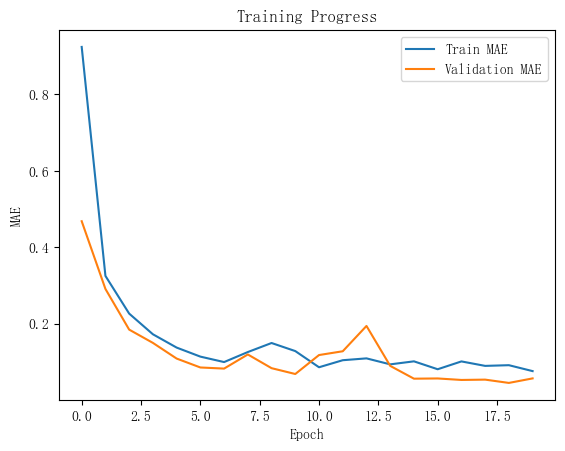

In [5]:
# 结果分析
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training Progress')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [6]:
# ================== 模型预测与评估 ==================
def evaluate_moe(model, test_file, scaler, time_scales=['30min']):
    # 加载测试数据
    test_data, _,test_time  = preprocess_data(test_file, time_scales)
    
    # 准备多尺度测试输入
    X_test_list = [data[0] for data in test_data.values()]
    y_test = list(test_data.values())[0][1]
    time_index = test_time[time_scales[0]]  # 获取主要时间尺度的索引
    # 模型预测
    predictions = model.predict(X_test_list)
    
    # 反归一化处理
    def inverse_scale(data, scaler, feature_index=3):
        data = np.squeeze(data)  # 新增展平操作
        dummy = np.zeros(shape=(len(data), scaler.n_features_in_))
        dummy[:, feature_index] = data
        return scaler.inverse_transform(dummy)[:, feature_index]

    # 获取实际价格序列
    real_prices = inverse_scale(y_test, scaler)
    predicted_prices = inverse_scale(predictions, scaler)

    # 计算评估指标
    mse = mean_squared_error(real_prices, predicted_prices)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(real_prices, predicted_prices)
    r2 = r2_score(real_prices, predicted_prices)
    # 返回指标字典
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Predictions': predicted_prices,
        'Actuals': real_prices
    }, time_index

In [7]:


# 模型保存
# moe_model.save('moe_stock_predictor.h5')

result, time_index = evaluate_moe(moe_model, '../data/', scaler)
print(f"model predict result \n{result}")

专家 0 输入形状: (32, 60, 31) 配置: 31 units
Concatenated shape: (32, 1, 1)
Expert 0 output shape: (32, 1)
Attention输出形状: (32, 1, 1)


d:\Programs\miniconda3\envs\tf310\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
d:\Programs\miniconda3\envs\tf310\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4038/4040 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step专家 0 输入形状: (None, 60, 31) 配置: 31 units
Concatenated shape: (None, 1, 1)
Expert 0 output shape: (None, 1)
Attention输出形状: (None, 1, 1)
4040/4040 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

d:\Programs\miniconda3\envs\tf310\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
d:\Programs\miniconda3\envs\tf310\lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


4040/4040 ━━━━━━━━━━━━━━━━━━━━ 77s 19ms/step
model predict result 
{'MSE': 2853885.081484257, 'RMSE': np.float64(1689.3445715674043), 'MAE': 1293.7591372138972, 'R2': -0.8650928148882688, 'Predictions': array([ 91.5087759 ,  96.74194136,  85.06794546, ..., 201.91733045,
       202.64150928, 202.90163821]), 'Actuals': array([ 311.  ,  307.5 ,  306.23, ..., 1908.  , 1904.8 , 1905.17])}


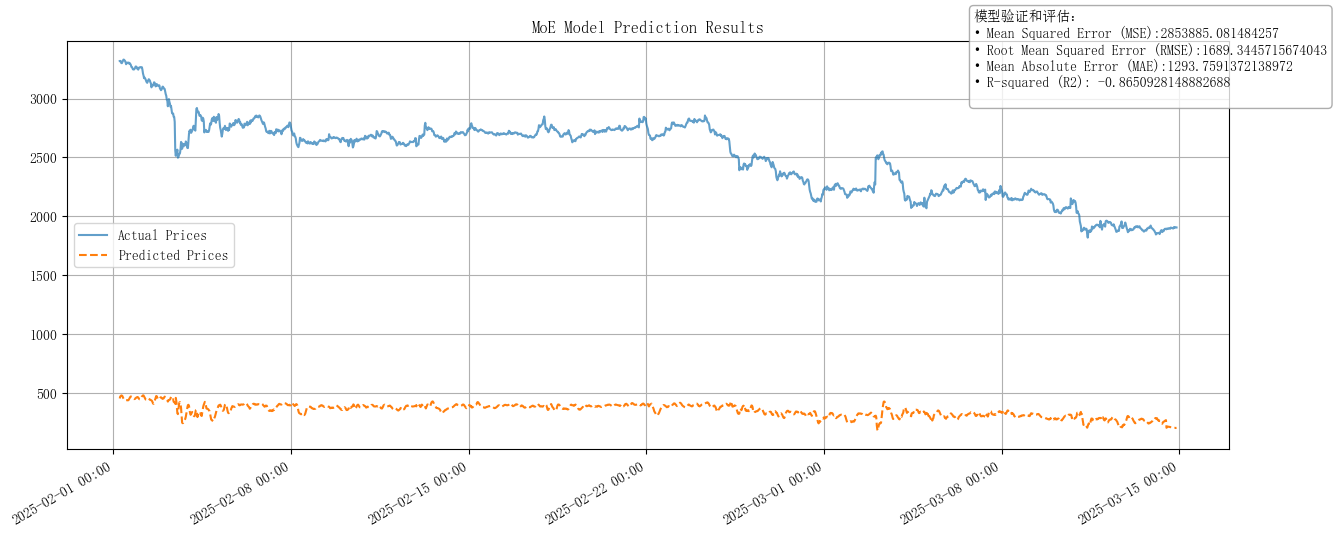

In [8]:

n = 2000
# 可视化对比
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(time_index[-n:],result['Actuals'][-n:], label='Actual Prices', alpha=0.7)
plt.plot(time_index[-n:],result['Predictions'][-n:], label='Predicted Prices', linestyle='--')
plt.title(f'MoE Model Prediction Results')
plt.gcf().autofmt_xdate()  # 自动优化日期显示
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
# # 添加统计信息框
stats_text = f"""模型验证和评估：
• Mean Squared Error (MSE):{result['MSE']}
• Root Mean Squared Error (RMSE):{result['RMSE']}
• Mean Absolute Error (MAE):{result['MAE']}
• R-squared (R2): {result['R2']}
"""

plt.annotate(stats_text, 
            xy=(0.78, 0.85), 
            xycoords='axes fraction',
            bbox=dict(boxstyle="round", fc="white", ec="#999999", alpha=0.8))
plt.legend()
plt.grid(True)
plt.savefig('moe_prediction_comparison.png')
plt.show()